# r/feminism experiment analysis
J. Nathan Matias, Nov 12, 2019

In [201]:
library(MASS)
library(ggplot2)
library(gmodels) #contains CrossTable
library(ri2)
options(repr.plot.width=7, repr.plot.height=3)
newcomers <- read.csv("../data/r-feminism-study-data-merged-10.17.2019.csv",
                          stringsAsFactors = FALSE)
newcomers$complied = newcomers$completed_survey=="True"
newcomers$message.sent = newcomers$message_status == "sent"
newcomers$num.comments <- newcomers$comments_2_weeks
newcomers$TREAT <- newcomers$treatment
newcomers$ingroup <- newcomers$identify_feminist=="Yes"
newcomers$inclusion <- newcomers$community_closeness

sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ri2_0.1.2        estimatr_0.14    randomizr_0.16.1 gmodels_2.18.1  
[5] ggplot2_3.1.0    MASS_7.3-51.1   

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.0       pillar_1.3.1     compiler_3.5.1   plyr_1.8.4      
 [5] base64enc_0.1-3  tools_3.5.1      digest_0.6.18    uuid_0.1-2      
 [9] jsonlite_1.6     evaluate_0.13    tibble_2.0.0     gtable_0.2.0    
[13] texreg_1.36.23   pkgconfig_2.0.2  rlang_0.3.0.1    IRdisplay_0.7.0 
[17] IRkernel_0.8.14  stringr_1.3.1    repr_0.19.1      wi

# Codebook


#### Study Participation
* **message.sent**: Was the intervention sent to the account? (true) or had it been entirely banned by reddit by the point at which we attempted to send the intervention (false)
* **complied**: Did the account complete the survey?
* **TREAT**: Did the account receive the intervention? (1)
* **assignment_datetime**: When was the account assigned to join the study?
* **block_id**: What randomization block was the account in?

#### Comments
* **comments_2_weeks**:: The number of comments made by the account over 2 weeks
* **comments_4_weeks**:: The number of comments made by the account over 2 weeks
* **comments_8_weeks**:: The number of comments made by the account over 2 weeks

#### Bans
* **ban_actions**: The total number of within-subreddit ban actions received by the account
* **ban_days_two_weeks**: The number of days the account was banned from posting in the subreddit over 2 weeks
* **ban_days_four_weeks**: The number of days the account was banned from posting in the subreddit over 4 weeks
* **ban_days_eight_weeks**: The number of days the account was banned from posting in the subreddit over 8 weeks

#### Post-Survey Responses
* **ingroup**: Did the account report identifying as a feminist when they first commented in the community?
* **inclusion**: The reported closeness to the r/feminism community on a scale of 1 to 7


### Summary Statistics

In [202]:
summary(factor(newcomers$treatment))

0   1 
498 487

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4995  0.0000 27.0000 

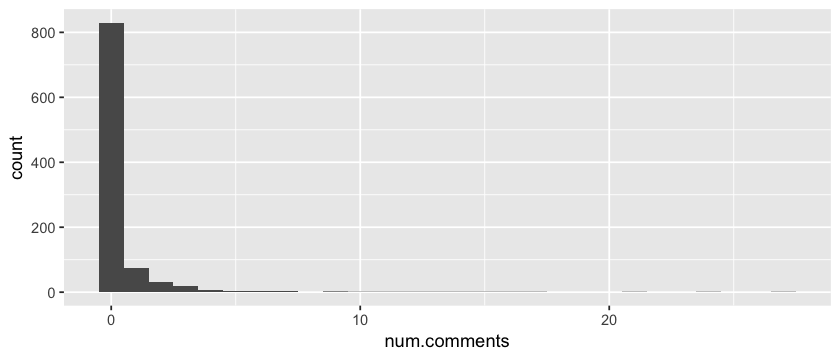

In [173]:
summary(newcomers$num.comments)
ggplot(newcomers, aes(num.comments)) +
    geom_histogram(binwidth=1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       2       4       4       6       7 

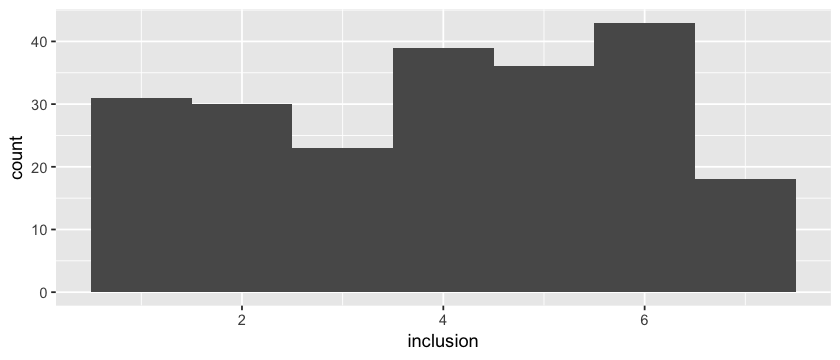

In [204]:
summary(subset(newcomers, complied)$inclusion)
ggplot(subset(newcomers, complied), aes(inclusion)) +
    geom_histogram(binwidth=1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   1.403   0.000  14.000 

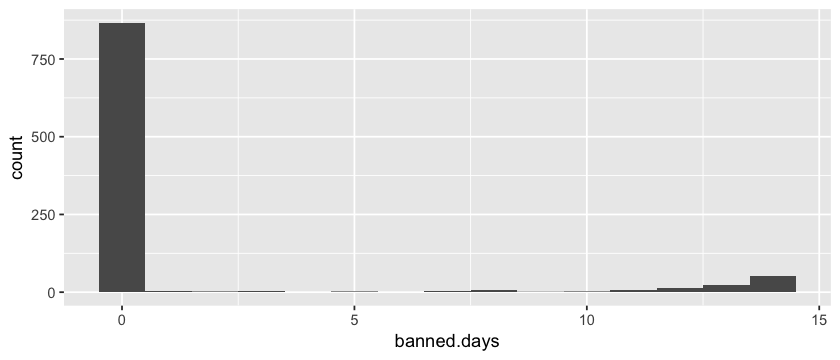

In [205]:
newcomers$banned.days <- newcomers$ban_days_2_weeks
summary(newcomers$banned.days)
ggplot(newcomers, aes(banned.days)) +
    geom_histogram(binwidth=1)

In [206]:
summary(factor(subset(newcomers, complied)$identify_feminist))
summary(newcomers$ingroup)

No Undecided       Yes 
       43        17       160

   Mode   FALSE    TRUE 
logical     825     160 

# Questions about Balance in the Sample

In [208]:
## How can we make sense of the message_status field, which should
## indicate that the account never received the intervention?
summary(factor(newcomers$message.sent))
CrossTable(newcomers$message.sent, newcomers$treatment, prop.chisq = FALSE, prop.t = FALSE)
CrossTable(newcomers$message.sent, newcomers$complied, prop.chisq = FALSE, prop.t = FALSE)

FALSE  TRUE 
  146   839


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  985 

 
                       | newcomers$treatment 
newcomers$message.sent |         0 |         1 | Row Total | 
-----------------------|-----------|-----------|-----------|
                 FALSE |        73 |        73 |       146 | 
                       |     0.500 |     0.500 |     0.148 | 
                       |     0.147 |     0.150 |           | 
-----------------------|-----------|-----------|-----------|
                  TRUE |       425 |       414 |       839 | 
                       |     0.507 |     0.493 |     0.852 | 
                       |     0.853 |     0.850 |           | 
-----------------------|-----------|-----------|-----------|
          Column Total |       498 |       487 |       985 | 
                       |     0.506 |     0.494 |           | 
------------

In [178]:
## What is the balance among survey compliers 
## and among accounts that identified as feminist

summary(newcomers$complied)
CrossTable(newcomers$complied, newcomers$treatment, prop.chisq = FALSE, prop.t = FALSE)
CrossTable(subset(newcomers, complied)$identify_feminist, subset(newcomers, complied)$treatment, prop.chisq = FALSE, prop.t = FALSE)

   Mode   FALSE    TRUE 
logical     765     220 


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  985 

 
                   | newcomers$treatment 
newcomers$complied |         0 |         1 | Row Total | 
-------------------|-----------|-----------|-----------|
             FALSE |       383 |       382 |       765 | 
                   |     0.501 |     0.499 |     0.777 | 
                   |     0.769 |     0.784 |           | 
-------------------|-----------|-----------|-----------|
              TRUE |       115 |       105 |       220 | 
                   |     0.523 |     0.477 |     0.223 | 
                   |     0.231 |     0.216 |           | 
-------------------|-----------|-----------|-----------|
      Column Total |       498 |       487 |       985 | 
                   |     0.506 |     0.494 |           | 
-------------------|-----------|-----------|-----------|

 

 
 

### Create Measure of Comments Per Day

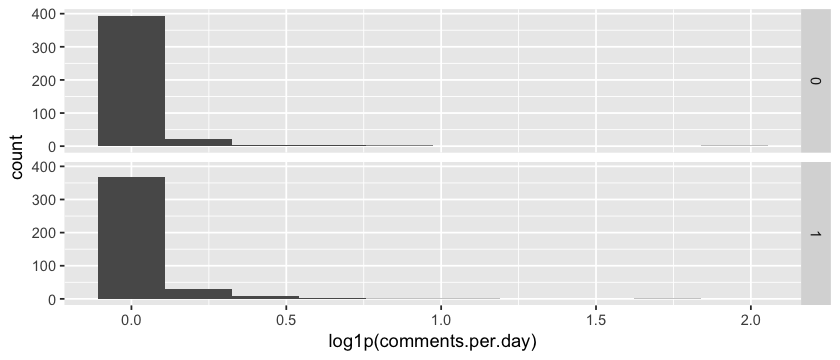

In [210]:
newcomers$eligible.days <- 14 - newcomers$banned.days
newcomers$comments.per.day <- newcomers$num.comments / (newcomers$eligible.days + 1)
ggplot(subset(newcomers, message.sent), aes(log1p(comments.per.day))) +
    geom_histogram(bins=10) +
    facet_grid(treatment ~ . )

# Bivariate Analysis

### Feminist and Closeness to Community

Warning message:
“Removed 765 rows containing non-finite values (stat_bin).”

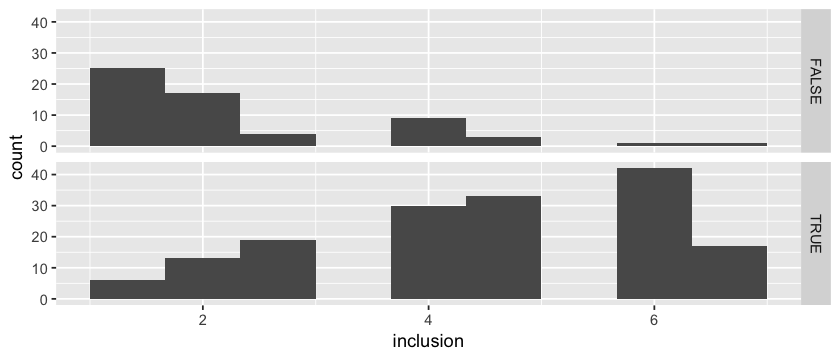

In [211]:
ggplot(newcomers, aes(inclusion)) +
    geom_histogram(bins=10) +
    facet_grid(ingroup ~ . )

# Analyze Results

In [212]:
summary(glm.nb(num.comments ~ treatment + banned.days, data= subset(newcomers, message.sent)))


Call:
glm.nb(formula = num.comments ~ treatment + banned.days, data = subset(newcomers, 
    message.sent), init.theta = 0.09261885155, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6305  -0.6218  -0.5543  -0.5543   2.9609  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.931608   0.183352  -5.081 3.75e-07 ***
treatment    0.507090   0.247255   2.051   0.0403 *  
banned.days  0.004767   0.030749   0.155   0.8768    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0926) family taken to be 1)

    Null deviance: 335.33  on 838  degrees of freedom
Residual deviance: 331.20  on 836  degrees of freedom
AIC: 1252.4

Number of Fisher Scoring iterations: 1


              Theta:  0.0926 
          Std. Err.:  0.0111 

 2 x log-likelihood:  -1244.4440 

In [213]:
summary(glm.nb(num.comments ~ treatment + banned.days, data= subset(newcomers, complied)))


Call:
glm.nb(formula = num.comments ~ treatment + banned.days, data = subset(newcomers, 
    complied), init.theta = 0.1524106293, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8525  -0.8525  -0.7203  -0.2191   2.2876  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept) -0.38014    0.28399  -1.339  0.18070   
treatment    0.78624    0.39010   2.015  0.04385 * 
banned.days -0.23357    0.08066  -2.896  0.00378 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.1524) family taken to be 1)

    Null deviance: 133.99  on 219  degrees of freedom
Residual deviance: 119.34  on 217  degrees of freedom
AIC: 458.51

Number of Fisher Scoring iterations: 1


              Theta:  0.1524 
          Std. Err.:  0.0291 

 2 x log-likelihood:  -450.5110 

# Inclusion of the Group in the Self Scale

In [214]:
summary(lm(inclusion ~ treatment, data= subset(newcomers, complied)))


Call:
lm(formula = inclusion ~ treatment, data = subset(newcomers, 
    complied))

Residuals:
     Min       1Q   Median       3Q      Max 
-3.09524 -1.91304  0.08696  1.90476  3.08696 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.9130     0.1775  22.041   <2e-16 ***
treatment     0.1822     0.2570   0.709    0.479    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.904 on 218 degrees of freedom
Multiple R-squared:  0.0023,	Adjusted R-squared:  -0.002276 
F-statistic: 0.5027 on 1 and 218 DF,  p-value: 0.4791


In [215]:
summary(lm(inclusion ~ treatment + banned.days, data= subset(newcomers, complied)))


Call:
lm(formula = inclusion ~ treatment + banned.days, data = subset(newcomers, 
    complied))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3655 -1.3039 -0.0433  1.6345  2.6961 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.30390    0.16651  25.848  < 2e-16 ***
treatment    0.06160    0.22968   0.268    0.789    
banned.days -0.20713    0.02738  -7.565 1.09e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.697 on 217 degrees of freedom
Multiple R-squared:  0.2105,	Adjusted R-squared:  0.2033 
F-statistic: 28.93 on 2 and 217 DF,  p-value: 7.262e-12
